In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

import findspark
findspark.init()
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml import Transformer
from pyspark.sql import DataFrame
from pyspark.ml.feature import StopWordsRemover
import re

In [ ]:
spark1 = SparkSession.builder.master("local[16]").appName("TOT") .getOrCreate()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/training_noemoticon.csv", encoding='latin-1')

In [ ]:
from numpy.random import default_rng

arr_indices_top_drop = default_rng().choice(df.index, size=40000, replace=False)
df = df.drop(index=arr_indices_top_drop)
len(df)

1000000

In [ ]:
# path = "/content/training_noemoticon.csv"

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)])

# df = spark1.read.csv(path, inferSchema=True, header=False, schema=schema)
df = spark1.createDataFrame(df, schema = schema) 
df.dropna()

DataFrame[target: int, id: string, date: string, query: string, author: string, tweet: string]

In [ ]:
class WordFormatter(Transformer):
    def __init__(self, *, inputCol, outputCol):

        super(WordFormatter, self).__init__()
        self.regpat = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b')
        self.ponc = [',', '.', '?', '-']
        self.inputCol = inputCol
        self.outputCol = outputCol

    def stopw(self, wt):

        filtered_sentence = []

        # for all the words
        for w in wt["filtered"]:
            wrd = w.strip().lower()

            # we check if the unwanted punctuation is present, we remove it if yes
            for char in self.ponc:
                wrd = wrd.replace(char, '')

            # we do not keep words with a URL, empty word, word ' ' or words with '@'
            if not re.fullmatch(self.regpat, wrd) and wrd != ' ' and wrd != '' and '@' not in wrd:
                filtered_sentence.append(wrd)

        # returns the row as it was but with our list added
        return wt[0], wt[1], wt[2], wt[3], wt[4], wt[5], wt[6], filtered_sentence

    def _transform(self, dtf: DataFrame) -> DataFrame:

        # apply PySpark's stop words
        rem = StopWordsRemover(inputCol=self.inputCol, outputCol="filtered")
        ndtf = rem.transform(dtf)

        # apply our additional function to better filter
        rdd = ndtf.rdd.map(lambda x: self.stopw(x))
        ndtf = rdd.toDF()

        # reset the starting column names
        official_col = ['target', 'id', 'date', 'query', 'author', 'tweet', self.inputCol, self.outputCol]

        for old, new in zip(ndtf.columns, official_col):
            ndtf = ndtf.withColumnRenamed(old, new)

        return ndtf

In [ ]:
(train_set, test_set) = df.randomSplit([0.80, 0.20], seed = 2000)

In [ ]:
print(test_set)

DataFrame[target: int, id: string, date: string, query: string, author: string, tweet: string]


In [ ]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tweet: string (nullable = true)



Logistic Regression

HashingTF - IDF


In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="tk")
wordform = WordFormatter(inputCol="tk", outputCol="words")

hashtf = HashingTF(inputCol="words", outputCol='tf')

idf = IDF(inputCol='tf', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, wordform, hashtf, idf, label_stringIdx, lr])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
test_set.show()

+------+----------+--------------------+--------+--------------+--------------------+
|target|        id|                date|   query|        author|               tweet|
+------+----------+--------------------+--------+--------------+--------------------+
|     0|1468163470|Tue Apr 07 00:03:...|NO_QUERY|        CoriiB|@junebugg15  I ha...|
|     0|1468174290|Tue Apr 07 00:07:...|NO_QUERY|   emmaketurah|@GillianMe Yeah h...|
|     0|1468268489|Tue Apr 07 00:38:...|NO_QUERY|     ElmosSexy|Nothing was sick ...|
|     0|1468566578|Tue Apr 07 02:27:...|NO_QUERY|        djpain|Leanne is angry a...|
|     0|1470042551|Tue Apr 07 08:10:...|NO_QUERY|     MCeubanks|Rock Fore Dough i...|
|     0|1548667787|Fri Apr 17 21:36:...|NO_QUERY|     LoserLisa|okay. Goodnight T...|
|     0|1548725027|Fri Apr 17 21:46:...|NO_QUERY|       skoosie|I accidentally lo...|
|     0|1550967115|Sat Apr 18 07:46:...|NO_QUERY| michellehdz95|thinking what i a...|
|     0|1551796573|Sat Apr 18 09:59:...|NO_QUERY|     

Data Visualization

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

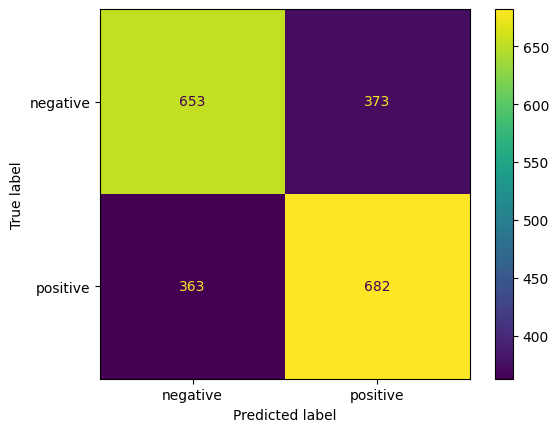

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Live tweet fetching 

In [ ]:
# spark1.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
self_tweets = []
self_tweetText = []


In [ ]:
import tweepy
import pandas as pd
from datetime import datetime
consumerKey = "HzkqDfV6TdmpyL7xkBujJJ3Lf"
consumerSecret ="WtTqpgp9Uv1OpNpeg3CtOfrKJ7NwMh0GelIXrz3ECPUkXFWjjE"
accessToken =  "1652625534151704576-BpkZitgvOYYVkHPI897TpshTKHYuxj"
accessTokenSecret = "yOVNPgAS2DfHqnIlKv8qP6lw84hwDfZFXKjyr0NSfF56W"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

# input for term to be searched and how many tweets to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

# searching for tweets
self_tweets = tweepy.Cursor(api.search_tweets, q=searchTerm, lang = "en").items(NoOfTerms)

col = ['target', 'id', 'date', 'query', 'author', 'tweet']

li = []
i = 0
for tweet in self_tweets:
    li.append((0, 123456+i, datetime.utcnow(), 'NO_QUERY', tweet.author.name, tweet.text))
    i+=1

Enter Keyword/Tag to search about: IPL
Enter how many tweets to search: 100


In [ ]:
livedf = pd.DataFrame(li, columns=col)

In [ ]:
live_df = spark1.createDataFrame(livedf, schema = schema) 
live_df.dropna()

DataFrame[target: int, id: string, date: string, query: string, author: string, tweet: string]

In [ ]:
# live_df.show()

+------+------+--------------------+--------+--------------------+--------------------+
|target|    id|                date|   query|              author|               tweet|
+------+------+--------------------+--------+--------------------+--------------------+
|     0|123456|java.util.Gregori...|NO_QUERY|                Akad|RT @thecaspiansk:...|
|     0|123457|java.util.Gregori...|NO_QUERY| 😪துரோகம் பண்ணவன்😔|RT @mufaddal_vohr...|
|     0|123458|java.util.Gregori...|NO_QUERY|🏟 Featherbed Slo...|@hide_it0 @imVic1...|
|     0|123459|java.util.Gregori...|NO_QUERY|        Rajesh M-059|RT @Cricketracker...|
|     0|123460|java.util.Gregori...|NO_QUERY|Justin Bieber Ind...|RT @HustlerCSK_: ...|
|     0|123461|java.util.Gregori...|NO_QUERY|         The OG 🦁😎|RT @Kohli_Dewotee...|
|     0|123462|java.util.Gregori...|NO_QUERY|  Afghan Atalan 🇦🇫|Yet another impre...|
|     0|123463|java.util.Gregori...|NO_QUERY|      Ashish A Pawar|RT @bollywood_lif...|
|     0|123464|java.util.Gregori...|NO_

In [ ]:
predictions = pipelineFit.transform(live_df)

In [ ]:
# predictions.show()

+------+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|target|    id|                date|   query|              author|               tweet|                  tk|               words|                  tf|            features|label|       rawPrediction|         probability|prediction|
+------+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|     0|123456|java.util.Gregori...|NO_QUERY|                Akad|RT @thecaspiansk:...|[rt, @thecaspians...|[rt, tomorrow, #n...|(262144,[8977,291...|(262144,[8977,291...|  1.0|[-182.20312248351...|[7.41633467489450...|       1.0|
|     0|123457|java.util.Gregori...|NO_QUERY| 😪துரோகம் பண்ணவன்😔|RT @mufaddal

In [ ]:
predictions.select(['prediction']).show()

+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



In [ ]:
live_df = predictions.select(["prediction"]).toPandas()

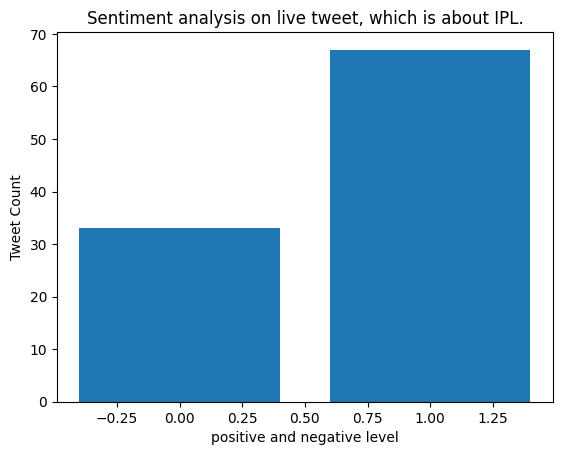

In [ ]:
import matplotlib.pyplot as plt
value_counts = live_df['prediction'].value_counts()

plt.bar(value_counts.index, value_counts.values)

# Set labels and title
plt.title(f'Sentiment analysis on live tweet, which is about {searchTerm}.')
plt.xlabel('positive and negative level')
plt.ylabel('Tweet Count')

# Show the chart
plt.show()

CountVectorizer + NGram + ChisQSelector

In [ ]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    lr = [LogisticRegression()]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)

In [ ]:
%%time

# import datetime
# st = datetime.utcnow()
pipelineFit = build_trigrams().fit(train_set)
# print('Training time:', datetime.utcnow() - st)
predictions = pipelineFit.transform(test_set)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6426846933848382
Precision: 0.6428012477714546
Recall: 0.6426846933848382
CPU times: user 4.71 s, sys: 576 ms, total: 5.28 s
Wall time: 12min 49s


Data visualisation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

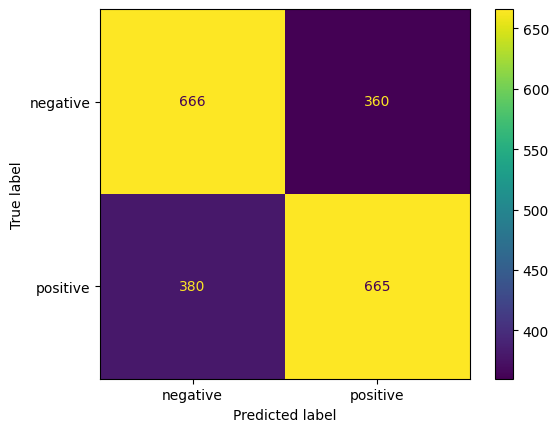

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Support Vector Machine

In [ ]:
from pyspark.ml.classification import LinearSVC


Creation of pipeline

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, svm])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6982134234669242
Precision: 0.6982037625849091
Recall: 0.6982134234669242
CPU times: user 1.43 s, sys: 236 ms, total: 1.67 s
Wall time: 3min 2s


HashingTF - IDF

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, svm])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6938676967648479
Precision: 0.6944152122196121
Recall: 0.6938676967648478
CPU times: user 930 ms, sys: 198 ms, total: 1.13 s
Wall time: 1min 29s


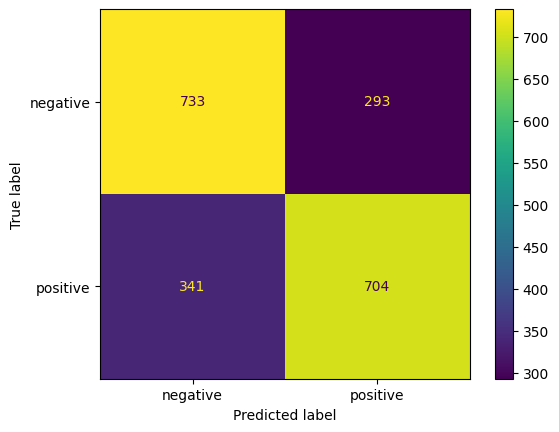

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])

Live tweet fetching

In [ ]:
self_tweets = []
self_tweetText = []

In [ ]:
import tweepy
import pandas as pd
from datetime import datetime
consumerKey = "HzkqDfV6TdmpyL7xkBujJJ3Lf"
consumerSecret ="WtTqpgp9Uv1OpNpeg3CtOfrKJ7NwMh0GelIXrz3ECPUkXFWjjE"
accessToken =  "1652625534151704576-BpkZitgvOYYVkHPI897TpshTKHYuxj"
accessTokenSecret = "yOVNPgAS2DfHqnIlKv8qP6lw84hwDfZFXKjyr0NSfF56W"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

# input for term to be searched and how many tweets to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

# searching for tweets
self_tweets = tweepy.Cursor(api.search_tweets, q=searchTerm, lang = "en").items(NoOfTerms)

col = ['target', 'id', 'date', 'query', 'author', 'tweet']

li = []
i = 0
for tweet in self_tweets:
    li.append((0, 123456+i, datetime.utcnow(), 'NO_QUERY', tweet.author.name, tweet.text))
    i+=1

Enter Keyword/Tag to search about: Chat Gpt
Enter how many tweets to search: 100


In [ ]:
livedf = spark1.createDataFrame(livedf, schema = schema) 
livedf.dropna()

DataFrame[target: int, id: string, date: string, query: string, author: string, tweet: string]

In [ ]:
predictions = pipelineFit.transform(livedf)

In [ ]:
livedf = predictions.select(["prediction"]).toPandas()

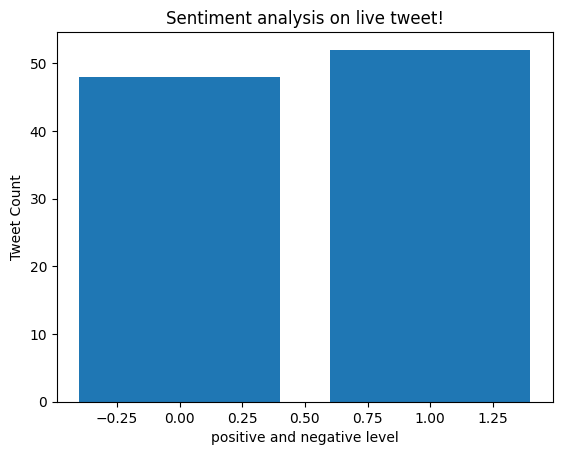

In [ ]:
import matplotlib.pyplot as plt
value_counts = livedf['prediction'].value_counts()

plt.bar(value_counts.index, value_counts.values)

# Set labels and title
plt.title('Sentiment analysis on live tweet!')
plt.xlabel('positive and negative level')
plt.ylabel('Tweet Count')

# Show the chart
plt.show()

CountVectorizer + NGram + ChisQSelector

In [ ]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    svm = [LinearSVC()]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + svm)

In [ ]:
%%time
pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6702076291646547
Precision: 0.6704259394365999
Recall: 0.6702076291646548
CPU times: user 7.93 s, sys: 891 ms, total: 8.82 s
Wall time: 22min 30s


Stats

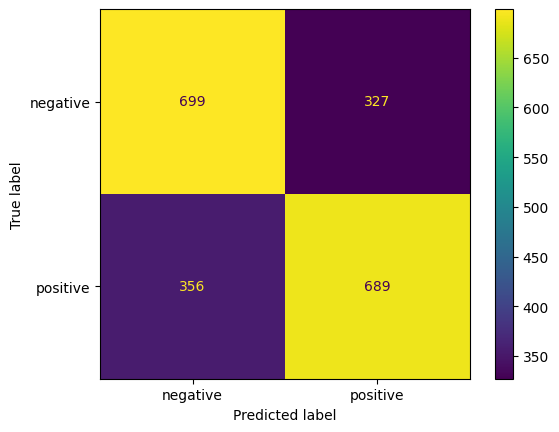

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])